In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy.stats import norm
from torch import optim
from tqdm import tqdm
import torch
import seaborn as sns
import pyro
import numpy.testing as np_testing
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from scipy.special import expit, logit
from sklearn.model_selection import train_test_split

from IPython.display import clear_output

sns.set(font_scale=1.5, rc={'figure.figsize':(11.7, 8.27)})

# 0. Seminar plan

    1. Fit binomial distribution to the space worms teeth distribution using KL Divergence, Reverse KL Divergence and Jensen-Shannon Divergence;
    2. Fit 2D-normal distribution;
        - with KL Divergence;
        - with rKL Divergence;
    3. Feel frustration and surprise and learn the horrible truth about rKL;
    4. Take a glance at what happens in GANs;
        - fit another network to approximate computation of KL/rKL;
    5. Apply new knowledge to fit 2D-normal distribution.
    
    
###### Btw, f-divergences are classical statistical tool originally...

![](https://miro.medium.com/max/1432/1*hXK4F_vFtG-fh2BrxDolFg.jpeg)


# 1. Discrete example

In this notebook we're going to take a look at a way of comparing two probability distributions called Kullback-Leibler Divergence. 

## 1.1 Space worms teeth distribution

Suppose that we're space-scientists visiting a distant, new planet and we've discovered a species of biting worms that we'd like to study. We've found that these worms have 10 teeth, but because of all the chomping away, many of them end up missing teeth. After collecting many samples we have come to this empirical probability distribution of the number of teeth in each worm:
 
![Space worms](https://images.squarespace-cdn.com/content/v1/54e50c15e4b058fc6806d068/1494401025139-ODE7CP2043TS1CO9MQSN/ke17ZwdGBToddI8pDm48kLuT3KTpMRZ2imBrzIWD9_5Zw-zPPgdn4jUwVcJE1ZvWEtT5uBSRWt4vQZAgTJucoTqqXjS3CfNDSuuf31e0tVG-_BClLJADi5Tjms1vR9XfE3ardhQXleMJTem2-1ZqRideLm3HbGNLisCtv4-dzhc/biting-worms.jpg?format=1000w)

Picture and idea credits: https://www.countbayesie.com/blog/2017/5/9/kullback-leibler-divergence-explained

In [2]:
# ensure the probability adds up to 1
true_data = torch.tensor([0.1, 0.2, 0.11, 0.11, 0.05, 0.02, 0.03, 0.05, 0.11, 0.15, 0.07])
n = true_data.shape[0]
index = torch.arange(n).float()

In [3]:
np_testing.assert_almost_equal(true_data.sum().item(), 1., err_msg='Your probabilities do not sum up to 1!')

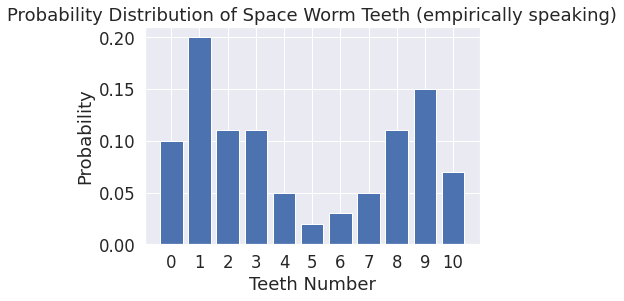

In [4]:
plt.figure()
plt.bar(index, true_data)
plt.xlabel('Teeth Number')
plt.title('Probability Distribution of Space Worm Teeth (empirically speaking)')
plt.ylabel('Probability')
plt.xticks(index)
plt.show()

## 1.2 Hypothesis about the data

###### Hypothesis 1: uniform distribution of space worms teeth

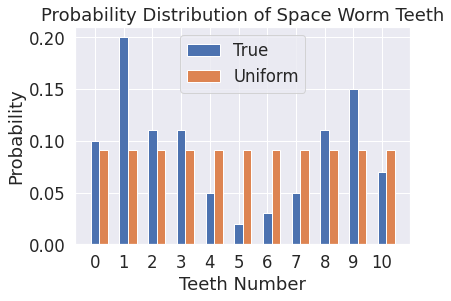

In [5]:
uniform_data = torch.full((n, ), 1.0 / n)

plt.figure()
# we can plot our approximated distribution against the original distribution
width = 0.3
plt.bar(index, true_data, width=width, label='True')
plt.bar(index + width, uniform_data, width=width, label='Uniform')
plt.xlabel('Teeth Number')
plt.title('Probability Distribution of Space Worm Teeth')
plt.ylabel('Probability')
plt.xticks(index)
plt.legend()
plt.show()

###### Hypothesis 2: binomial distribution with unknown parameter $p$


###### Introducing a new framework: Pyro
Pyro is a flexible, scalable deep probabilistic programming library built on PyTorch. (c) https://github.com/pyro-ppl/pyro

In [6]:
import pyro
from pyro import distributions as distrs

In [7]:
# we estimate the parameter of the binomial distribution
p = true_data.dot(index) / n
print('p for binomial distribution:', p)
binomial_dist = distrs.Binomial(total_count=n, probs=p)
binom_data = binomial_dist.log_prob(index).exp()
binom_data

p for binomial distribution: tensor(0.4100)


tensor([0.0030, 0.0231, 0.0801, 0.1670, 0.2321, 0.2258, 0.1569, 0.0779, 0.0271,
        0.0063, 0.0009])

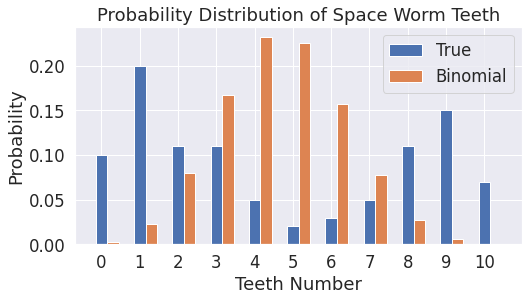

In [8]:
plt.figure(figsize=(8, 4))
width = 0.3
plt.bar(index, true_data, width=width, label='True')
plt.bar(index + width, binom_data, width=width, label='Binomial')
plt.xlabel('Teeth Number')
plt.title('Probability Distribution of Space Worm Teeth')
plt.ylabel('Probability')
plt.xticks(np.arange(n))
plt.legend()
plt.show()

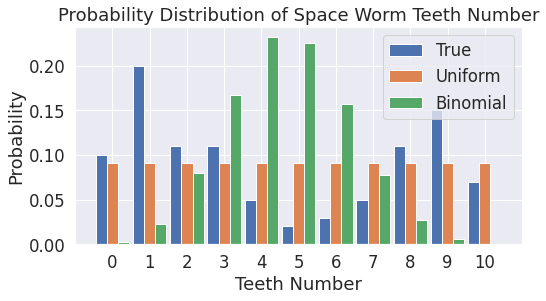

In [9]:
plt.figure(figsize=(8, 4))
plt.bar(index - width, true_data, width=width, label='True')
plt.bar(index, uniform_data, width=width, label='Uniform')
plt.bar(index + width, binom_data, width=width, label='Binomial')
plt.xlabel('Teeth Number')
plt.title('Probability Distribution of Space Worm Teeth Number')
plt.ylabel('Probability')
plt.xticks(index)
plt.legend()
plt.show()

## 1.3 Task: Implementing KL Divergance for a discrete distribution

$$KL ( P||Q ) = \int_{R^n}p(x)\log\left( \frac{p(x)}{q_{\theta}(x)}\right) dx$$

In [10]:
def compute_kl_divergence(p_probs: torch.Tensor, q_probs: torch.Tensor):
    """"
    KL (P || Q) = \int_{R^n}p(x)\log\left( \frac{p(x)}{q_{\theta}(x)}\right) = 
                = \sum_i p_i log(p_i / q_i)
    
    Note:
        1. The output -- kl_div -- should be one number that is equal to KL (P || Q)
        2. Do not forget to clamp your probabilities to avoid log(0) and (x / 0) problems!
    """
    EPS = 1e-7
    q_probs, p_probs = q_probs.clamp(min=EPS), p_probs.clamp(min=EPS)
    kl_div = (p_probs * (p_probs / q_probs).log()).sum()
    return kl_div

In [11]:
true_data_testing = torch.tensor([0.1, 0.2, 0.11, 0.11, 0.05, 0.02, 0.03, 0.05, 0.11, 0.15, 0.07])
uniform_data_testing = torch.full((n, ), 1.0 / n)
binomial_dist = distrs.Binomial(total_count=n, probs=true_data.dot(index) / n).log_prob(index).exp()


print('KL(True||Uniform): ', compute_kl_divergence(true_data, uniform_data))
np_testing.assert_almost_equal(compute_kl_divergence(true_data, uniform_data).item(), 0.16362181305885315, decimal=3)

print('KL(Uniform||True): ', compute_kl_divergence(uniform_data, true_data))
np_testing.assert_almost_equal(compute_kl_divergence(uniform_data, true_data).item(), 0.1930386871099472, decimal=3)


print('KL(True||Binomial): ', compute_kl_divergence(true_data, binom_data))
np_testing.assert_almost_equal(compute_kl_divergence(true_data, binom_data).item(), 1.5118370056152344, decimal=3)


print('KL(Binomial||True): ', compute_kl_divergence(binom_data, true_data))
np_testing.assert_almost_equal(compute_kl_divergence(binom_data, true_data).item(), 1.1197633743286133, decimal=3)

KL(True||Uniform):  tensor(0.1636)
KL(Uniform||True):  tensor(0.1930)
KL(True||Binomial):  tensor(1.5118)
KL(Binomial||True):  tensor(1.1198)


## 1.4 Task: Implementing JS Divergance for a discrete distribution

In [12]:
def compute_js_divergence(p_probs, q_probs):
    """"
    JS (P || Q) = (KL(P || Q) + KL(Q || P)) / 2
    Note:
        1. The output should be one number that is equal to KL (P || Q)
    """
    kl_div = compute_kl_divergence(p_probs, q_probs)
    rkl_div = compute_kl_divergence(q_probs, p_probs)
    return (kl_div + rkl_div) / 2

In [13]:
true_data_testing = torch.tensor([0.1, 0.2, 0.11, 0.11, 0.05, 0.02, 0.03, 0.05, 0.11, 0.15, 0.07])
uniform_data_testing = torch.full((n, ), 1.0 / n)
binomial_dist = distrs.Binomial(total_count=n, probs=true_data.dot(index) / n).log_prob(index).exp()

print('JS(True||Uniform): ', compute_js_divergence(true_data, uniform_data))
np_testing.assert_almost_equal(compute_js_divergence(true_data, uniform_data).item(), 0.17833024263381958, decimal=3)

print('JS(Uniform||True): ', compute_js_divergence(uniform_data, true_data))
np_testing.assert_almost_equal(compute_js_divergence(uniform_data, true_data).item(), 0.17833024263381958, decimal=3)

print('JS(True||Binomial): ', compute_js_divergence(true_data, binom_data))
np_testing.assert_almost_equal(compute_js_divergence(true_data, binom_data).item(), 1.3158001899719238, decimal=3)

print('JS(Binomial||True): ', compute_js_divergence(binom_data, true_data))
np_testing.assert_almost_equal(compute_js_divergence(binom_data, true_data).item(), 1.3158001899719238, decimal=3)

JS(True||Uniform):  tensor(0.1783)
JS(Uniform||True):  tensor(0.1783)
JS(True||Binomial):  tensor(1.3158)
JS(Binomial||True):  tensor(1.3158)


## 1.5 Implementing JS Divergance for a discrete distribution

##### Firslty, a few words about backpropagation

In [14]:
p

tensor(0.4100)

In [15]:
p = torch.tensor(0.5, requires_grad=True)

In [16]:
binomial_dist = distrs.Binomial(total_count=n, probs=p)
binom_data = binomial_dist.log_prob(index).exp()
binom_data

tensor([0.0005, 0.0054, 0.0269, 0.0806, 0.1611, 0.2256, 0.2256, 0.1611, 0.0806,
        0.0269, 0.0054], grad_fn=<ExpBackward>)

#### Notice that now we have `grad_fn=<ExpBackward>`

In [17]:
kl = compute_kl_divergence(true_data, binom_data)

In [18]:
kl

tensor(1.6910, grad_fn=<SumBackward0>)

#### Because KL have  `grad_fn=<SumBackward0>` we can apply `.backward()` method to compute the gradients w.r.t. `p`

In [19]:
kl.backward()

In [20]:
p, p.grad

(tensor(0.5000, requires_grad=True), tensor(3.9600))

### 1.6 Task: Implementing optimization procedure

In [21]:
from collections import defaultdict
EPS = 1e-3
2
def optimize_binomial_distribution(func, p, true_data, lr: float=1e-3, epochs: int=1000):
    """
    func: distance function that takes two arguments
    p: initial guess on parameter p of binomial distribution
    true_data: true_data
    lr: learning rate
    epochs: number of training iterations
    """
    p = p.clone().detach().requires_grad_(True)
    history = defaultdict(list)
    opt = optim.Adam([p], lr=lr)
    
    n = len(true_data)
    index = torch.arange(n).float()
    
    for i in range(epochs):
        p.data.clamp_(EPS, 1 - EPS)
        # Here your task is to 
        # 1. create binomial distribution with Pyro
        # 2. calculate p.d.f. of the binomial distribution
        # 3. apply func to true_data and p.d.f. from previous step
        # 4. perform usual backprop
        # Do not forget to zero grad after weights update!

        binomial_dist = distrs.Binomial(total_count=n, probs=p)
        binom_data = binomial_dist.log_prob(index).exp()
        d = func(true_data, binom_data)
        d.backward()
        opt.step()
        opt.zero_grad()

        history['epoch'].append(i)
        history['dist'].append(d.item())
        history['p'].append(p.item())

    return p, history

### 1.6.1 Task: Fitting with KL-Divergence

In [22]:
optimal_p, hist = optimize_binomial_distribution(compute_kl_divergence, p, true_data)
print(optimal_p)

tensor(0.4100, requires_grad=True)


In [23]:
np_testing.assert_almost_equal(optimal_p.item(), 0.4099, decimal=3)

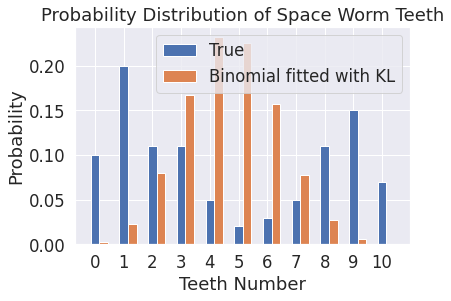

In [24]:
binom_data = distrs.Binomial(total_count=n, probs=optimal_p).log_prob(index).exp().detach()
plt.figure()
width = 0.3
plt.bar(index, true_data, width=width, label='True')
plt.bar(index + width, binom_data, width=width, label='Binomial fitted with KL')
plt.xlabel('Teeth Number')
plt.title('Probability Distribution of Space Worm Teeth')
plt.ylabel('Probability')
plt.xticks(np.arange(n))
plt.legend()
plt.show()

### 1.6.2 Task: Fitting with rKL-Divergence

In [25]:
optimal_p, hist = optimize_binomial_distribution(lambda x, y: compute_kl_divergence(y, x), p, true_data)
print(optimal_p)

tensor(0.9973, requires_grad=True)


In [26]:
np_testing.assert_almost_equal(optimal_p.item(), 0.9973, decimal=3)

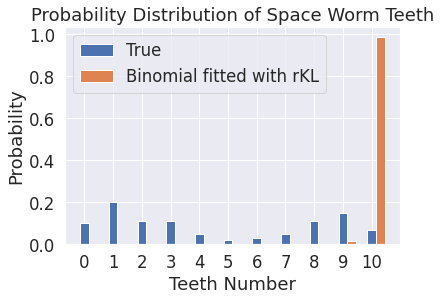

In [27]:
binom_data = distrs.Binomial(total_count=n, probs=optimal_p).log_prob(index).exp().detach()
binom_data = binom_data / binom_data.sum()
plt.figure()
width = 0.3
plt.bar(index, true_data, width=width, label='True')
plt.bar(index + width, binom_data, width=width, label='Binomial fitted with rKL')
plt.xlabel('Teeth Number')
plt.title('Probability Distribution of Space Worm Teeth')
plt.ylabel('Probability')
plt.xticks(np.arange(n))
plt.legend()
plt.show()

### 1.6.3 Task: Fitting with JS-Divergence

In [28]:
optimal_p, hist = optimize_binomial_distribution(lambda x, y: compute_js_divergence(y, x), p, true_data)
print(optimal_p)

tensor(0.3484, requires_grad=True)


In [29]:
np_testing.assert_almost_equal(optimal_p.item(), 0.3484, decimal=3)

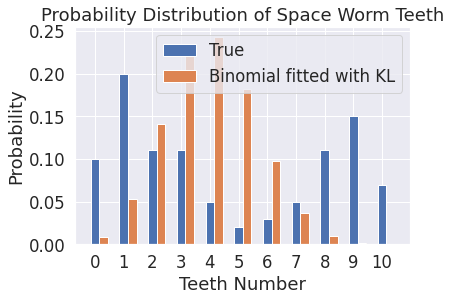

In [30]:
binom_data = distrs.Binomial(total_count=n, probs=optimal_p).log_prob(index).exp().detach()
plt.figure()
width = 0.3
plt.bar(index, true_data, width=width, label='True')
plt.bar(index + width, binom_data, width=width, label='Binomial fitted with KL')
plt.xlabel('Teeth Number')
plt.title('Probability Distribution of Space Worm Teeth')
plt.ylabel('Probability')
plt.xticks(np.arange(n))
plt.legend()
plt.show()

## 1.7 Compare divergence profiles

In [31]:
ps = torch.linspace(0. + EPS, 1. - EPS, 100)

In [32]:
rkls = [
    compute_kl_divergence(distrs.Binomial(total_count=n, probs=p).log_prob(index).exp(), true_data) for p in ps
]

kls = [
    compute_kl_divergence(true_data, distrs.Binomial(total_count=n, probs=p).log_prob(index).exp()) for p in ps
]

jss = [
    compute_js_divergence(distrs.Binomial(total_count=n, probs=p).log_prob(index).exp(), true_data) for p in ps
]

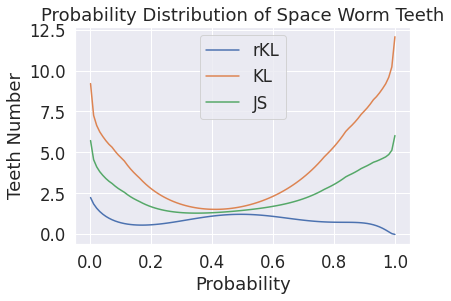

In [33]:
plt.figure()
plt.plot(ps, rkls, label='rKL')
plt.plot(ps, kls, label='KL')
plt.plot(ps, jss, label='JS')
plt.title('Probability Distribution of Space Worm Teeth')
plt.ylabel('Teeth Number')
plt.xlabel('Probability')
plt.legend()
plt.show()

# 2. Fitting 2D-normal distribution

Credits: my collegues that https://github.com/HSE-LAMBDA/DeepGenerativeModels

#### Supplementary functions

In [34]:
from pyro.distributions import MultivariateNormal
def plot_2d_dots(dots, color='blue', label='None'):
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.scatter(dots[:, 0], dots[:, 1], s=1, c=color, label=label)


def get_parameters(mu=0., sigma=1.):
    train_mu = torch.Tensor([mu, mu]).requires_grad_(True)
    train_sigma = torch.Tensor([[sigma, 0.0],
                                [0.0, sigma]]).requires_grad_(True)
    return train_mu, train_sigma

def create_distr(mu, sigma):
    return distrs.MultivariateNormal(mu, sigma)


def sample(d, num):
    return d.sample(torch.Size([num]))

class MixtureDistribution:
    def __init__(self, p1, p2, w=0.5):
        self._p1 = p1
        self._p2 = p2
        self._w = w
        
    def sample(self, n):
        return torch.cat([sample(self._p1, int(n * self._w)), sample(self._p2, n - int(n * self._w))])
    
    def log_prob(self, x):
        return (self._w * self._p1.log_prob(x).exp() + (1. - self._w) * self._p2.log_prob(x).exp()).log()

## 2. Target distribution

Target distribution is a mixture of two 2-dimensionals normal distributions.

### 2.1 Data Generation

Here we sampling training data from real distribution:


$$D_{train} = \{x\}_{i=1}^{n} \sim p(x)$$

In [35]:
P1 = create_distr(
    mu=torch.Tensor([-5, -5]), 
    sigma=torch.Tensor([[1., 0.0], 
                        [0.0, 1.]])
)
P2 = create_distr(
    mu=torch.Tensor([4, 3]), 
    sigma=torch.Tensor([[1., 0.0], 
                        [0.0, 1.]])
)

P = MixtureDistribution(P1, P2, 0.5)

samples_x = P.sample(2000)
px = P.log_prob(samples_x).exp()

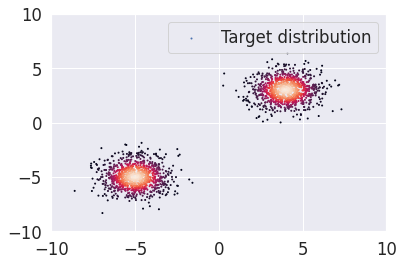

In [36]:
plt.figure()
plot_2d_dots(samples_x, color=px, label='Target distribution')
plt.legend()
plt.show()

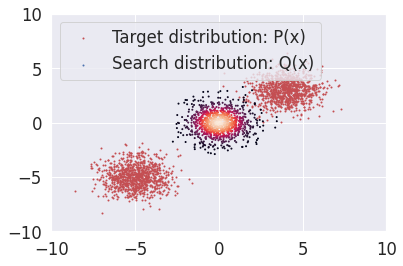

In [37]:
train_mu, train_sigma = get_parameters()

Q = create_distr(train_mu, train_sigma)
samples_q = sample(Q, 1000)
plt.figure()
plot_2d_dots(samples_x, color='r', label='Target distribution: P(x)')
plot_2d_dots(samples_q, color= Q.log_prob(samples_q).exp().detach(), label='Search distribution: Q(x)')

plt.legend()
plt.show()

### 2.2 Task: optimization of KL

In cases when the only thing you have is the data sampled from real distribution:

$$D_{train} = \{x\}_{i=1}^{n} \sim p(x)$$

To estimate KL divergance you can apply MC estimation. I.e.


$$KL ( P||Q ) = \int_{R^n}p(x)\log\left( \frac{p(x)}{q_{\theta}(x)}\right) dx \approx \sum\limits_{x \in D} p(x) \log\left( \frac{p(x)}{q(x)} \right)$$

In [38]:
def estimate_kl(samples_x, px, train_mu, train_sigma, P):
    """
    Here your task is to estimate KL divergance
    
    1. Create Q distribution with parameters train_mu and train_sigma
    2. Estimate qx on samples from real distribution
    3. apply function for KL computation
    """
    Q = create_distr(train_mu,  train_sigma)
    qx = Q.log_prob(samples_x).exp()
    loss = compute_kl_divergence(px, qx)
    return loss

In [39]:
train_mu, train_sigma = get_parameters(mu=0., sigma=1.)
samples_x_test = torch.linspace(-5, 5, 10).view(-1, 2)
px_test = P.log_prob(samples_x_test).exp()
np_testing.assert_almost_equal(estimate_kl(samples_x_test, px_test, train_mu, train_sigma, P).item(), 0.689806, decimal=3)

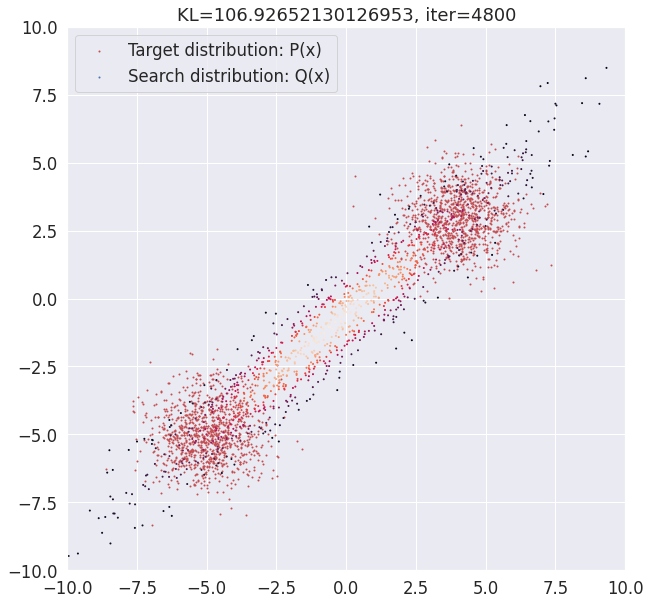

In [40]:
train_mu, train_sigma = get_parameters(mu=0., sigma=1.)
optim = torch.optim.Adam([train_mu, train_sigma], lr=1e-2)

for i in range(5000):
    # Here your task is to 
    # 1. create Q distribution with 
    # 2. calculate p.d.f. of the binomial distribution
    # 3. apply func to true_data and p.d.f. from previous step
    # 4. perform usual backprop
    # Do not forget to zero grad after weights update!

    optim.zero_grad()
    Q = create_distr(train_mu, train_sigma)
    loss = estimate_kl(samples_x, px, train_mu, train_sigma, P)
    loss.backward()
    optim.step()

    if i % 200 == 0:
        # plot pdfs
        clear_output(True)
        plt.figure(figsize=(10, 10))
        plt.title(f'KL={loss.item()}, iter={i}')
        plot_2d_dots(samples_x, color='r', label='Target distribution: P(x)')
        samples_q = sample(Q, 1000)
        plot_2d_dots(samples_q.detach(), color= Q.log_prob(samples_q).exp().detach(), label='Search distribution: Q(x)')
        plt.legend()
        plt.show()

### Sanity check: 

The search distribution should look like its trying to cover both modes of the target distribution. Like in the lecture :)

### 2.3 Task: optimization of rKL

###### Here you will understand: 
    - the hidden power of Pyro
    - what is wrong with rKL
    
    
    
To estimate rKL divergance you can apply MC estimation. I.e.


$$KL ( P||Q ) = \int_{R^n} q_{\theta}(x) \log\left( \frac{q_{\theta}(x)}{p(x)}\right) dx \approx \sum\limits_{x \in q(x)} q_{\theta}(x) \log\left( \frac{q_{\theta}(x)}{p(x)} \right)$$

###### Note that here we are averaging over samples from q(x)!

In [41]:
train_mu, train_sigma = get_parameters(mu=0., sigma=1.)
Q = create_distr(train_mu, train_sigma)

In [42]:
train_mu

tensor([0., 0.], requires_grad=True)

In [43]:
sample(Q, 10)

tensor([[ 0.1964, -1.1416],
        [-0.8590,  0.9492],
        [-0.9793,  0.5657],
        [ 0.8795,  0.0771],
        [ 1.3802, -0.1149],
        [-0.3734, -1.2918],
        [-0.9889, -0.4754],
        [ 1.1267, -1.4077],
        [ 2.4428,  1.8052],
        [-1.2718,  1.0317]])

In [44]:
def sample(d, num):
    """
    Sample from distribution num samples with __Pyro__
    """
    res = pyro.sample("dist", d.expand([num]))
    return res

In [45]:
train_mu, train_sigma = get_parameters(mu=0., sigma=1.)
Q = create_distr(train_mu, train_sigma)

In [46]:
train_mu

tensor([0., 0.], requires_grad=True)

In [47]:
sample(Q, 10)

tensor([[ 2.0249,  0.2866],
        [-0.7617,  0.9134],
        [-0.1141,  1.6116],
        [ 0.9123, -0.6338],
        [ 0.8665,  0.6578],
        [ 0.2140, -0.0635],
        [-1.4330,  0.6960],
        [ 1.1063,  0.3616],
        [ 0.7233, -0.4403],
        [ 0.2569, -0.7563]], grad_fn=<AddBackward0>)

In [48]:
def estimate_reverse_kl(samples_x, train_mu, train_sigma, P, n_samples=2000):
    """
    Here your task is to estimate rKL divergance
    
    1. Create Q distribution with parameters train_mu and train_sigma
    2. Sample(!) points x_q from Q distribution
    3. Estimate p(x_q)
    4. Estimate q(x_q)
    3. apply function for KL computation
    """
    Q = create_distr(train_mu, train_sigma)
    q = sample(Q, n_samples)
    px = P.log_prob(q).exp()
    qx = Q.log_prob(q).exp()
    loss = compute_kl_divergence(qx, px)
    return loss

In [49]:
train_mu, train_sigma = get_parameters(mu=0., sigma=1.)
samples_x_test = torch.linspace(-5, 5, 10).view(-1, 2)
px_test = P.log_prob(samples_x_test).exp()
torch.manual_seed(0)
np_testing.assert_almost_equal(estimate_reverse_kl(samples_x_test, train_mu, train_sigma, P, 2000).item(), 1965.1910400390625, decimal=3)
torch.manual_seed(np.random.randint(low=0, high=10000));

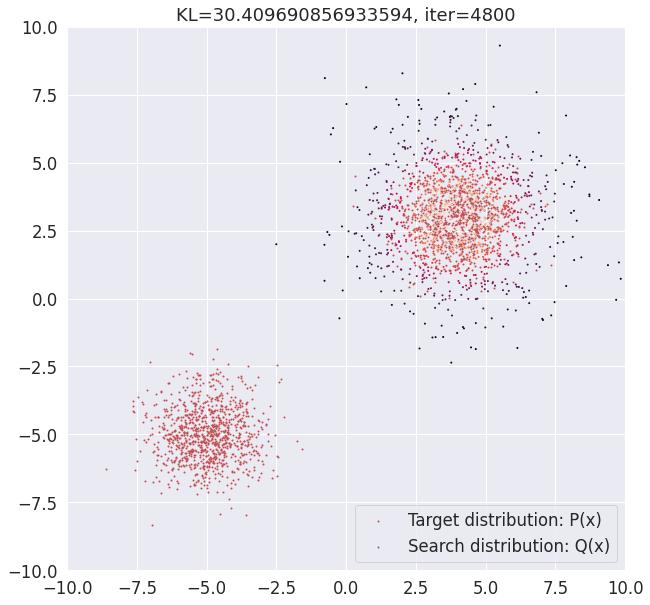

In [50]:
train_mu, train_sigma = get_parameters(mu=0.0, sigma=1.)

optim = torch.optim.Adam([train_mu, train_sigma], lr=1e-2)

for i in range(5000):
    optim.zero_grad()
    Q = create_distr(train_mu, train_sigma)
    loss = estimate_reverse_kl(samples_x, train_mu, train_sigma, P)
    loss.backward()
    optim.step()
    if i % 200 == 0:
        # plot pdfs
        clear_output(True)
        plt.figure(figsize=(10, 10))
        plt.title(f'KL={loss.item()}, iter={i}')
        plot_2d_dots(samples_x, color='r', label='Target distribution: P(x)')
        samples_q = sample(Q, 1000)
        plot_2d_dots(samples_q.detach(), color=Q.log_prob(samples_q).exp().detach(), label='Search distribution: Q(x)')
        plt.legend()
        plt.show()

### Sanity check: 

The search distribution should look like its trying to cover one mode of the target distribution. Like in the lecture :)

# 3. Breaking truth about rKL, many tears

_[here i will speak some truth]_


![](https://pbs.twimg.com/media/EUXNKoxXkAAgUQ4.jpg)

##### Let's go back to the square one and take a look on 1-dimensional normal distribution

Credits for some parts of code below: http://louistiao.me/notes/a-simple-illustration-of-density-ratio-estimation-and-kl-divergence-estimation-by-probabilistic-classification/

In [51]:
mu_p = torch.tensor(1.)
sigma_p = torch.tensor(1.)

In [52]:
mu_q = torch.tensor(0.)
sigma_q = torch.tensor(2.)

In [53]:
P = distrs.Normal(mu_p, sigma_p)
Q = distrs.Normal(mu_q, sigma_q)

In [54]:
xs = torch.tensor(np.linspace(-5., 5., 500)).float()

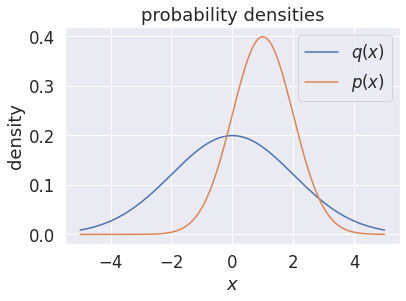

In [55]:
fig, ax = plt.subplots()

ax.set_title('probability densities')

ax.plot(xs, Q.log_prob(xs).exp(), label='$q(x)$')
ax.plot(xs, P.log_prob(xs).exp(), label='$p(x)$')

ax.set_xlim(-5.5, 5.5)

ax.set_xlabel('$x$')
ax.set_ylabel('density')

ax.legend()

plt.show()

## 3.1 Density Ratio

The ratio of their probability densities is given by,

$$
r(x) = \frac{p(x)}{q(x)}.
$$

In [56]:
density_ratio = lambda x, P, Q: P.log_prob(x).exp() / Q.log_prob(x).exp()

In [57]:
np_testing.assert_almost_equal(
    density_ratio(torch.tensor([1., 2., 3.]), P, Q).numpy(),
    np.array([2.266297 , 2.0000002, 0.833724]),
    decimal=1e-3
)

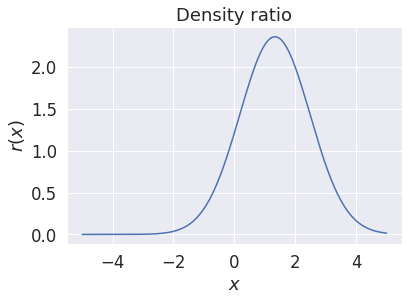

In [58]:
fig, ax = plt.subplots()

ax.set_title('Density ratio')

ax.plot(xs, density_ratio(xs, P, Q))

ax.set_xlim(-5.5, 5.5)
ax.set_xlabel('$x$')

ax.set_ylabel('$r(x)$')

plt.show()

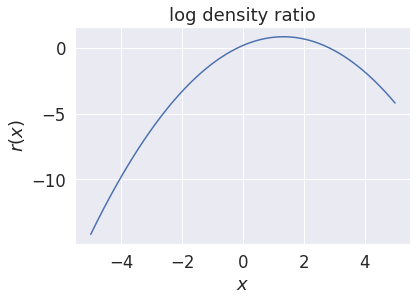

In [59]:
fig, ax = plt.subplots()

ax.set_title('log density ratio')

ax.plot(xs, np.log(density_ratio(xs, P, Q)))

ax.set_xlim(-5.5, 5.5)
ax.set_xlabel('$x$')

ax.set_ylabel('$r(x)$')

plt.show()

## 3.2 Density ratio estimation by probabilistic classification

Suppose now that we don't have access to the densities $p(x)$ and $q(x)$ for whatever reason, which is quite a common scenario. 

Density ratio estimation is concerned with directly estimating $r(x)$ using only samples from these distributions.One of the most simple approaches is __probabilistic classification__.

---

Let $\mathcal{D}_p = \{x_p^{(i)}\}_{i=1}^{n_p}$ and $\mathcal{D}_q = \{x_q^{(j)}\}_{j=1}^{n_q}$ be sets of samples drawn from distributions $p(x)$ and $q(x)$, respectively.

In [60]:
n_p = n_q = 500

In [61]:
samples_p = sample(P, n_p)
samples_q = sample(Q, n_p)

In [62]:
x = torch.cat([samples_p, samples_q]).view(-1, 1)
y = torch.cat([torch.ones_like(samples_p), 
               torch.zeros_like(samples_q)])

In [63]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=.2, random_state=1337
)

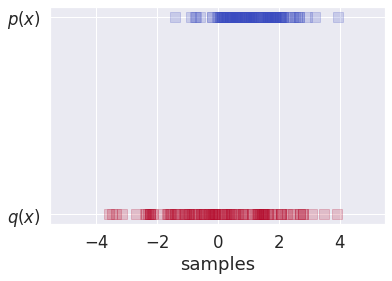

In [64]:
plt.figure()

plt.scatter(x_test, y_test, c=y_test, s=10.**2, 
           marker='s', alpha=.2, cmap='coolwarm_r')

plt.xlim(-5.5, 5.5)

plt.xlabel('samples')
plt.yticks([0, 1], ['$q(x)$', '$p(x)$'])

plt.show()

## 3.3 Bayes optimal classifier

The Bayes optimal classifier can be, __by definition__ written as a function of the density ratio,

$$
p(y=1 \mid x) = \sigma(\log r(x)) = \frac{p(x)}{p(x) + q(x)},
$$

where $\sigma$ is a sigmoid function.

We do not have an access to $p(x)$ and $q(x)$, thus we are building a classifier: $D_{\theta}(x) := \hat{p}(y = 1 \mid x)$. $D_{\theta}(x)$ could be a neural network any other classifier.

Thus, if classifier it well trained then $\hat{p}(y = 1 \mid x) \approx p(y = 1 \mid x)$.

Then ratio density for object $x$ could estimated via the __predicted probability by the trained classifer__ as follows:

$$
\begin{align}
\hat{r}(x)   = \frac{D(x)}{1 - D(x)}
           & = \exp \left ( \log \frac{D(x)}{1 - D(x)} \right ) \\
           & = \exp \left ( \sigma^{-1}(D(x)) \right ). \\
\end{align}                               
$$



In [65]:
classifier_optimal = lambda x, p, q: p.log_prob(x).exp() / (p.log_prob(x).exp() + q.log_prob(x).exp())

In [66]:
np_testing.assert_almost_equal(
    classifier_optimal(torch.tensor([1., 2., 3.]), P, Q).numpy(),
    np.array([0.6938429 , 0.6666667 , 0.45466167]),
    decimal=1e-3
)

In [67]:
y_pred_optimal = classifier_optimal(x_test, P, Q)

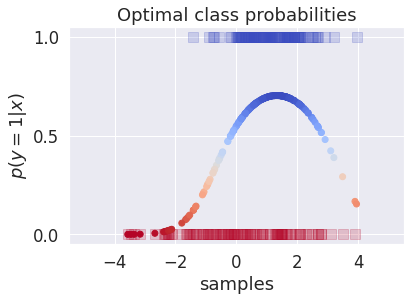

In [68]:
fig, ax = plt.subplots()

ax.set_title('Optimal class probabilities')

ax.scatter(x_test, y_test, c=y_test, s=10.**2, 
           marker='s', alpha=.2, cmap='coolwarm_r')

ax.scatter(x_test, y_pred_optimal, c=y_pred_optimal, cmap='coolwarm_r')

ax.set_xlim(-5.5, 5.5)
ax.set_xlabel('samples')

ax.set_yticks([0., .5, 1.])
ax.set_ylabel('$p(y=1|x)$')

plt.show()

In [69]:
from torch import nn
critic = nn.Sequential(
    nn.Linear(1, 16),
    nn.Tanh(),
    nn.Linear(16, 16),
    nn.Tanh(),
    nn.Linear(16, 1),
    nn.Sigmoid()
)

In [70]:
epochs = 500

optim = torch.optim.Adam(critic.parameters(), lr=1e-2)
ce = torch.nn.BCELoss()

hist = defaultdict(list)

for i in tqdm(range(epochs)):
    optim.zero_grad()
    probs = critic(x_train)
    loss = ce(probs.view(-1), y_train)
    probs = critic(x_test)
    loss_test = ce(probs.view(-1), y_test)
    hist['loss_train'].append(loss.item())
    hist['loss_test'].append(loss_test.item())
    loss.backward()
    optim.step()

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 2/500 [00:00<00:25, 19.46it/s]

  3%|▎         | 14/500 [00:00<00:18, 25.94it/s]

  6%|▌         | 31/500 [00:00<00:13, 34.76it/s]

  9%|▉         | 46/500 [00:00<00:10, 45.10it/s]

 13%|█▎        | 65/500 [00:00<00:07, 58.35it/s]

 16%|█▌        | 78/500 [00:00<00:06, 66.41it/s]

 19%|█▉        | 96/500 [00:00<00:04, 81.82it/s]

 22%|██▏       | 112/500 [00:00<00:04, 95.20it/s]

 26%|██▌       | 129/500 [00:00<00:03, 109.11it/s]

 29%|██▉       | 146/500 [00:01<00:02, 121.60it/s]

 32%|███▏      | 162/500 [00:01<00:02, 128.82it/s]

 36%|███▌      | 179/500 [00:01<00:02, 137.41it/s]

 39%|███▉      | 195/500 [00:01<00:02, 142.64it/s]

 42%|████▏     | 212/500 [00:01<00:01, 148.64it/s]

 46%|████▌     | 229/500 [00:01<00:01, 153.85it/s]

 49%|████▉     | 246/500 [00:01<00:01, 157.70it/s]

 53%|█████▎    | 263/500 [00:01<00:01, 153.04it/s]

 56%|█████▌    | 281/500 [00:01<00:01, 158.77it/s]

 60%|█████▉    | 298/500 [00:02<00:01, 158.21it/s]

 63%|██████▎   | 315/500 [00:02<00:01, 159.05it/s]

 66%|██████▋   | 332/500 [00:02<00:01, 161.81it/s]

 70%|██████▉   | 349/500 [00:02<00:00, 162.17it/s]

 73%|███████▎  | 366/500 [00:02<00:00, 163.66it/s]

 77%|███████▋  | 383/500 [00:02<00:00, 164.31it/s]

 80%|████████  | 400/500 [00:02<00:00, 164.84it/s]

 83%|████████▎ | 417/500 [00:02<00:00, 165.30it/s]

 87%|████████▋ | 435/500 [00:02<00:00, 166.98it/s]

 90%|█████████ | 452/500 [00:02<00:00, 166.52it/s]

 94%|█████████▍| 469/500 [00:03<00:00, 165.38it/s]

 98%|█████████▊| 488/500 [00:03<00:00, 170.53it/s]

100%|██████████| 500/500 [00:03<00:00, 155.29it/s]

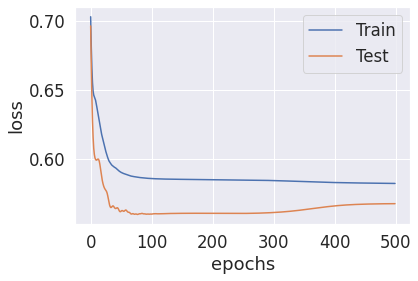

In [71]:
fig, ax = plt.subplots()

plt.plot(hist['loss_train'], label='Train')
plt.plot(hist['loss_test'], label='Test')

ax.set_ylabel('loss')
ax.set_xlabel('epochs')
plt.legend()

plt.show()

In [72]:
ys_optimal = classifier_optimal(xs, P, Q)
ys = critic(xs.view(-1, 1)).view(-1).detach()

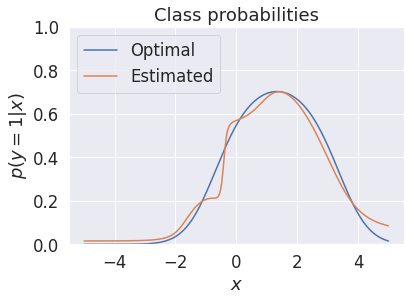

In [73]:
fig, ax = plt.subplots()

ax.set_title('Class probabilities')

ax.plot(xs, ys_optimal, label='Optimal')
ax.plot(xs, ys, label='Estimated')

ax.set_xlim(-5.5, 5.5)
ax.set_xlabel('$x$')

ax.set_ylim(0., 1.)
ax.set_ylabel('$p(y=1|x)$')

ax.legend()

plt.show()

## 3.4 Density ratio estimator

$$r = \mathrm{logit}(D(x))$$

Task is to implement `log_odds_fn(x, critic)` that implements $r$-calculation, i.e. (1) prediction, (2) logit-computation

In [74]:
def logit(x):
    return torch.log(x) - torch.log1p(-x)

log_odds_fn = lambda x, critic: logit(critic(x.view(-1, 1))).view(-1)

In [75]:
dummpy_critic = nn.Sequential(
    nn.Linear(1, 10),
    nn.Tanh(),
    nn.Linear(10, 1),
    nn.Sigmoid()
)
def init_weights(m):
    if isinstance(m, nn.Linear):
        m.weight.data.fill_(0.1)
        m.bias.data.fill_(0.1)
dummpy_critic.apply(init_weights)
np_testing.assert_almost_equal(
    log_odds_fn(torch.tensor([0., 1., 2.]), dummpy_critic).detach().numpy(),
    np.array([0.2  , 0.297, 0.391]),
    decimal=3
)

In [76]:
log_odds = log_odds_fn(xs, critic).detach()
log_density_ratios = np.log(density_ratio(xs, P, Q))

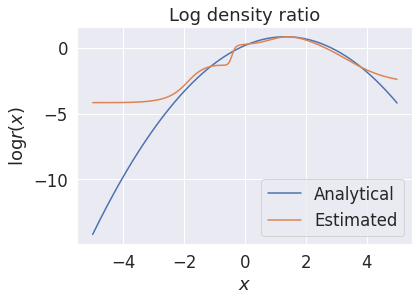

In [77]:
fig, ax = plt.subplots()

ax.set_title('Log density ratio')

ax.plot(xs, log_density_ratios, label='Analytical')
ax.plot(xs, log_odds, label='Estimated')

ax.set_xlim(-5.5, 5.5)
ax.set_xlabel('$x$')

ax.set_ylabel('$\log r(x)$')

ax.legend()

plt.show()

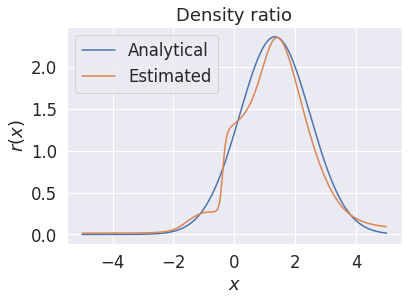

In [78]:
fig, ax = plt.subplots()

ax.set_title('Density ratio')

ax.plot(xs, density_ratio(xs, P, Q), label='Analytical')
ax.plot(xs, np.exp(log_odds), label='Estimated')

ax.set_xlim(-5.5, 5.5)
ax.set_xlabel('$x$')

ax.set_ylabel('$r(x)$')

ax.legend()

plt.show()

## 3.5 KL divergence estimation

A natural application of density ratio estimation is divergence estimation. Namely, approximating a divergence from the general family of $f$-divergences using only samples. Here, we will approximate the Kullback-Liebler (KL) divergence between $P$ and $Q$ without using their respective densities, $p(x)$ and $q(x)$.

In [79]:
mc_samples = 5000

In [80]:
samples_p = sample(P, mc_samples)

In [81]:
kl_mc = pd.Series(density_ratio(samples_p, P, Q).log())

In [82]:
kl_mc_dre = log_odds_fn(samples_p, critic).detach()
kl_mc_dre = pd.Series(kl_mc_dre)

In [83]:
kl_mc_dre

0       0.410487
1      -1.273344
2       0.846153
3       0.690058
4       0.796602
          ...   
4995    0.295127
4996   -0.355752
4997    0.849637
4998    0.414724
4999    0.803569
Length: 5000, dtype: float32

In [84]:
kl_estimates = pd.concat([kl_mc, kl_mc_dre], axis=1, 
                         keys=['kl_mc', 'kl_mc_dre'])
kl_estimates.describe()

,kl_mc,kl_mc_dre
count,5000.000000,5000.000000
mean,0.436589,0.355810
std,0.606818,0.617178
min,-4.952775,-3.779176
25%,0.304054,0.288182
50%,0.664622,0.519323
75%,0.816440,0.760457
max,0.859814,0.855528


#### KL divergence between Gaussians

For Gaussian distributions, the KL divergence can be evaluated analytically as,

$$
\log \sigma_q - \log \sigma_p - \frac{1}{2} 
    \left \{ 1 - \left (\frac{\sigma_p^2 + (\mu_p - \mu_q)^2}{\sigma_q^2} \right ) \right \}.
$$

In [85]:
def kl_divergence_gaussians(mu_p, sigma_p, mu_q, sigma_q):
    r = mu_p - mu_q
    return (np.log(sigma_q) - np.log(sigma_p) - .5 * (1. - (sigma_p**2 + r**2) / sigma_q**2))

In [86]:
kl_analytical = kl_divergence_gaussians(mu_p, sigma_p, mu_q, sigma_q)
kl_analytical

tensor(0.4431)

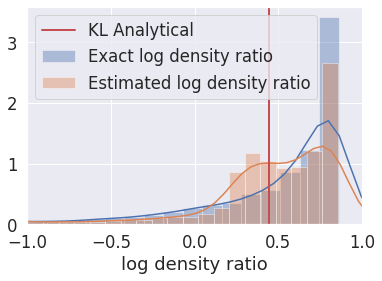

In [87]:
fig, ax = plt.subplots()

sns.distplot(kl_estimates.kl_mc, ax=ax, label='Exact log density ratio')
sns.distplot(kl_estimates.kl_mc_dre, ax=ax,  
             label='Estimated log density ratio')

ax.axvline(x=kl_analytical, color='r', linewidth=2., 
           label='KL Analytical')

ax.set_xlim(-1, 1)
ax.set_xlabel('log density ratio')

ax.legend()

plt.show()

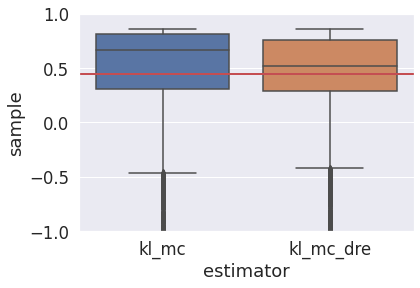

In [88]:
fig, ax = plt.subplots()

sns.boxplot(x='estimator', y='sample',
            data=pd.melt(kl_estimates, 
                         var_name='estimator', 
                         value_name='sample'), ax=ax)

ax.axhline(y=kl_analytical, color='r', linewidth=2., 
           label='Analytical')

ax.set_ylim(-1, 1)

plt.show()

In [89]:
# Cumulative mean of MC samples
kl_estimates_cum_mean = kl_estimates.expanding().mean()

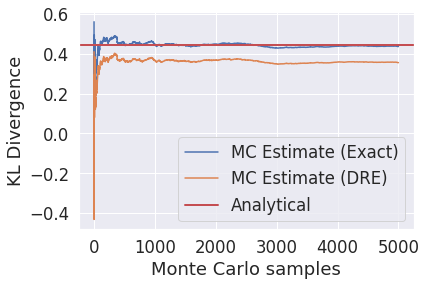

In [90]:
fig, ax = plt.subplots()

kl_estimates_cum_mean.plot(ax=ax, y='kl_mc', 
                           label='MC Estimate (Exact)')

kl_estimates_cum_mean.plot(ax=ax, y='kl_mc_dre', 
                           label='MC Estimate (DRE)', )

ax.axhline(y=kl_analytical, color='r', linewidth=2., 
           label='Analytical')

ax.set_xlabel('Monte Carlo samples')
ax.set_ylabel('KL Divergence')

ax.legend()

plt.show()

# 4. Example of how to combine density ratio estimation and rKL optimization

In [91]:
P1 = create_distr(
    mu=torch.Tensor([-5, -5]), 
    sigma=torch.Tensor([[1., 0.0], 
                        [0.0, 1.]])
)
P2 = create_distr(
    mu=torch.Tensor([4, 3]), 
    sigma=torch.Tensor([[1., 0.0], 
                        [0.0, 1.]])
)

P = MixtureDistribution(P1, P2, 0.5)

samples_p = P.sample(2000)
px = P.log_prob(samples_x).exp()

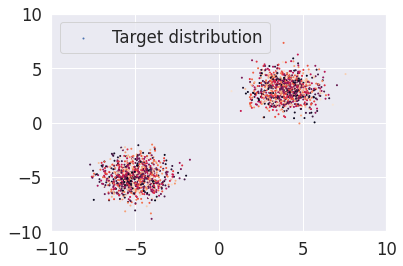

In [92]:
plt.figure()
plot_2d_dots(samples_p, color=px, label='Target distribution')
plt.legend()
plt.show()

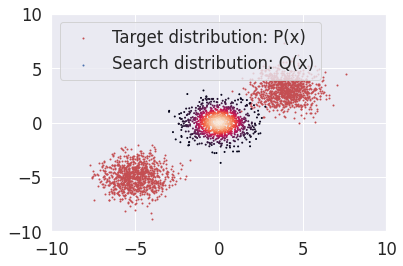

In [93]:
train_mu, train_sigma = get_parameters()

Q = create_distr(train_mu, train_sigma)
samples_q = sample(Q, 1000)
plt.figure()
plot_2d_dots(samples_p, color='r', label='Target distribution: P(x)')
plot_2d_dots(samples_q.detach(), color= Q.log_prob(samples_q).exp().detach(), label='Search distribution: Q(x)')

plt.legend()
plt.show()

In [94]:
def create_critic(x, y, input_dim=2, epochs=50):
    """
    This function create and train critic network with weights clipping
    """
    critic = nn.Sequential(
        nn.Linear(input_dim, 32),
        nn.Tanh(),
        nn.Linear(32, 32),
        nn.Tanh(),
        nn.Linear(32, 1),
        nn.Sigmoid()
    )
    critic_optim = torch.optim.Adam(critic.parameters(), lr=1e-3)
    ce = torch.nn.BCELoss()
    for _ in range(epochs):
        critic_optim.zero_grad()
        preds = critic(x).view(-1)
        loss = ce(preds, y)
        loss.backward()
        critic_optim.step()
    return critic

### Estimate Reverse KL Divergence

\begin{equation*}
 KL ( q_{\theta}||p  ) = \int_{R^n}q_{\theta}(x)\log\left( \frac{q_{\theta}(x)}{p(x)}\right) dx. 
\end{equation*}

So now I am interested in $r_{reverse} = \frac{q(x)}{p(x)}$.

To estimate it, we need sligtly modify formula from above:


$$
\begin{align}
\hat{r_{reverse}}(x) = \exp \left ( \sigma^{-1}(1 - D(x)) \right ). \\
\end{align}                               
$$



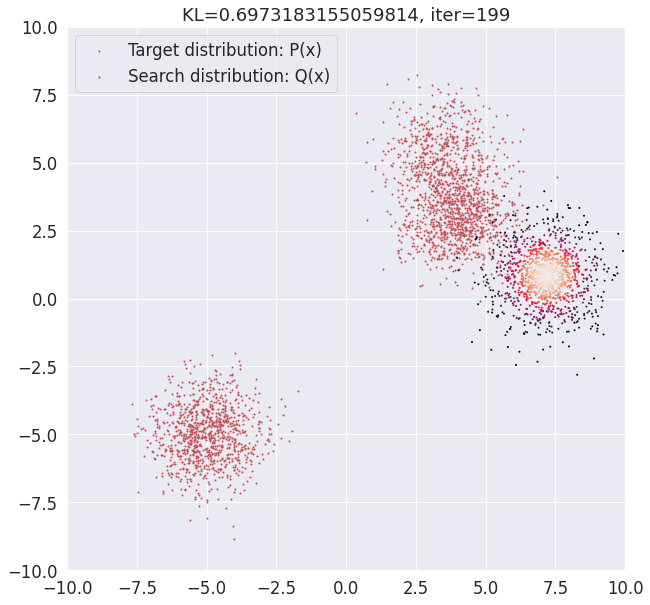

In [95]:
train_mu, train_sigma = get_parameters(mu=0.0, sigma=1.)
train_sigma = train_sigma.requires_grad_(False)

optim = torch.optim.SGD([train_mu, train_sigma], lr=10.)

for i in range(200):
    
    Q = create_distr(train_mu, train_sigma)
    samples_q = sample(Q, n_q).detach()
    x = torch.cat([samples_p, samples_q])
    y = torch.cat([torch.ones(len(samples_p)), 
                   torch.zeros(len(samples_q))])
    critic = create_critic(x, y)
    
    samples_q = sample(Q, n_q)
    critic(samples_q)
    optim.zero_grad()
    loss = (logit(1. - critic(samples_q))).view(-1).mean()
    loss.backward()
    
    optim.step()
    if i % 1 == 0:
        # plot pdfs
        clear_output(True)
        plt.figure(figsize=(10, 10))
        plt.title(f'KL={loss.item()}, iter={i}')
        plot_2d_dots(x, color='r', label='Target distribution: P(x)')
        samples_q = sample(Q, 1000)
        plot_2d_dots(samples_q.detach(), color=Q.log_prob(samples_q).exp().detach(), label='Search distribution: Q(x)')
        plt.legend()
        plt.show()

## Many problem, much pain
    1. Convergance issue, thats why I fixed `train_sigma`
    2. Slow convergance, thats why I am using lr=10
    3. Not reliable estimation of density ration
        - what if I overfitted?
        - what if I underfitted?
    4. Sometimes to get nice results you need to _restart training multiple times_
        - the same is applied to GANs!


![](https://i.redd.it/wvh152fq18c31.png)